In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_excel("Training Set.xlsx")

In [3]:
data

,Date,Hour,Weekday,Is Working Day,Previous Hour Price,SDSH DAP,SDSH Volume,Sgn0 VolumeDir,P24HA Price,PDSH Price,PWSH Price,PWA Price,target
0,2020-01-08 00:00:00,1,4,7,2400.41,2479.45,1383.7,-100.7,3654.911667,2473.00,1837.47,2296.059524,2475.68
1,2020-01-08 01:00:00,2,4,7,2475.68,2494.00,1339.3,-44.4,3655.023333,2459.38,1434.83,2299.858393,2484.40
2,2020-01-08 02:00:00,3,4,7,2484.40,2474.85,1309.4,-29.9,3656.065833,2370.61,1498.33,2306.105833,2486.89
3,2020-01-08 03:00:00,4,4,7,2486.89,2478.66,1294.7,-14.7,3660.910833,2021.43,1462.42,2311.990119,2533.42
4,2020-01-08 04:00:00,5,4,7,2533.42,2809.63,1361.4,66.7,3682.243750,2176.48,1455.85,2318.365119,2850.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7579,2020-11-18 19:00:00,20,4,5,1470.69,1886.14,1892.6,-23.4,1624.207917,1584.67,1303.85,1442.281607,1453.59
7580,2020-11-18 20:00:00,21,4,5,1453.59,1358.54,1850.3,-42.3,1618.746250,1599.34,1311.11,1443.172917,1463.07
7581,2020-11-18 21:00:00,22,4,5,1463.07,1772.66,1759.8,-90.5,1613.068333,1922.86,1368.03,1444.077440,1937.00
7582,2020-11-18 22:00:00,23,4,5,1937.00,1700.50,1668.2,-91.6,1613.657500,1719.45,1335.67,1447.464167,1924.55


## Basic EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7584 entries, 0 to 7583
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 7584 non-null   datetime64[ns]
 1   Hour                 7584 non-null   int64         
 2   Weekday              7584 non-null   int64         
 3   Is Working Day       7584 non-null   int64         
 4   Previous Hour Price  7584 non-null   float64       
 5   SDSH DAP             7584 non-null   float64       
 6   SDSH Volume          7584 non-null   float64       
 7   Sgn0 VolumeDir       7584 non-null   float64       
 8   P24HA Price          7584 non-null   float64       
 9   PDSH Price           7584 non-null   float64       
 10  PWSH Price           7584 non-null   float64       
 11  PWA Price            7584 non-null   float64       
 12  target               7584 non-null   float64       
dtypes: datetime64[ns](1), float64(9),

In [5]:
data.describe()

,Hour,Weekday,Is Working Day,Previous Hour Price,SDSH DAP,SDSH Volume,Sgn0 VolumeDir,P24HA Price,PDSH Price,PWSH Price,PWA Price,target
count,7584.000000,7584.000000,7584.000000,7584.000000,7584.000000,7584.000000,7584.000000,7584.000000,7584.000000,7584.000000,7584.000000,7584.000000
mean,12.500000,4.000000,4.572785,2429.484570,2327.516847,1587.817563,0.017128,2433.184528,2426.827399,2464.853534,2442.328138,2429.366103
std,6.922643,1.996965,1.390982,1590.715120,1419.109180,213.112880,73.092988,1125.325853,1564.734896,1605.184755,870.873043,1590.750740
min,1.000000,1.000000,1.000000,124.160000,87.380000,1079.800000,-465.200000,1145.512917,124.160000,124.160000,1409.440833,124.160000
25%,6.750000,2.000000,4.000000,1664.395000,1651.850000,1400.975000,-50.425000,1722.828854,1666.838500,1676.697500,1813.919442,1664.347500
50%,12.500000,4.000000,5.000000,1945.810000,1922.320000,1583.300000,-16.200000,2029.105417,1951.465000,1967.165000,2060.332396,1945.700000
75%,18.250000,6.000000,5.000000,2568.547500,2507.287500,1757.625000,43.300000,2725.680729,2595.940000,2603.567500,2823.226385,2568.547500
max,24.000000,7.000000,8.000000,10117.855409,9548.439791,2192.300000,661.200000,7691.478347,10117.855409,10117.855409,5520.089733,10117.855409


### Correlation Matrix Plot

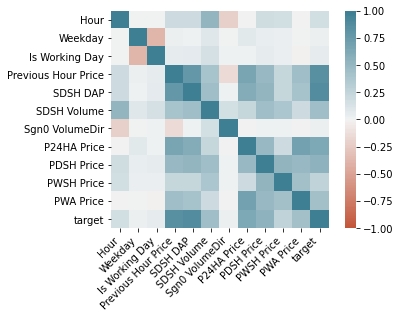

In [6]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#### Got a good diagonal!!

## Checking Unique Values for Onehot Encode

In [7]:
data['Is Working Day'].unique()

array([7, 5, 2, 4, 6, 3, 8, 1])

In [8]:
data['Weekday'].unique()

array([4, 5, 6, 7, 1, 2, 3])

## Checking Missing Values

In [9]:
data.isna().sum()

Date                   0
Hour                   0
Weekday                0
Is Working Day         0
Previous Hour Price    0
SDSH DAP               0
SDSH Volume            0
Sgn0 VolumeDir         0
P24HA Price            0
PDSH Price             0
PWSH Price             0
PWA Price              0
target                 0
dtype: int64

## Narrative:
- As all the columns are numerical but  "Is Working Day", "Weekday", needs to be one hot encoded as they are categorical by nature.

- I will extract features from Date column using datetime object.

- No Missing Values

- target is the target column and I will extract all others features with the current features.

#"REGRESSION TASK"
Let's start!!

## I will do this using 2 different ways:
- Sklearn's Pipeline
- PyCaret

# Using Pipeline

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Data Preparation Workflow:
- Extract features from Date Column using Dateobject. I am keeping in mind that I will use this model for future predictions so I wil drop Year in Date column because that will not make any sense for future predictions. Month, Day, and Hour will play an important role in the model performance.

- X and y

- Split X and y

- Tree-based models don't require scaled data so I will not use StandardScaler in this case of the Pipeline.

- month will be a categorical feature again so we need to onehot encode that.

In [11]:
def preprocess_inputs(df):
  df = df.copy()
  #Extract month, day, and hour using Datetime object
  df['Date'] = pd.to_datetime(df['Date']) #datetime object
  df['month'] = df['Date'].apply(lambda x: x.month) #extract month from datetime object
  df['day'] = df['Date'].apply(lambda x: x.day) #extract day from the datetime object
  df['hour'] = df['Date'].apply(lambda x: x.hour) #extract hour from the datetime object

  #Now I can drop the original Date column
  df = df.drop("Date", axis=1)

  # X and y
  X = df.drop("target", axis=1)
  y = df['target']

  #Split
  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, shuffle=True, random_state=1)
  
  return X_train, X_test, y_train, y_test

In [12]:
 X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [13]:
X_train

,Hour,Weekday,Is Working Day,Previous Hour Price,SDSH DAP,SDSH Volume,Sgn0 VolumeDir,P24HA Price,PDSH Price,PWSH Price,PWA Price,month,day,hour
5985,10,1,4,1291.63,1389.956667,1461.9,92.1,1598.885000,2740.61,2740.61,3946.715190,9,13,9
4793,18,7,2,2436.99,2404.500000,1639.0,14.6,2608.913333,1970.79,1970.79,2654.401942,7,25,17
854,15,4,5,4842.97,4685.140000,1824.5,-100.5,3451.281667,4804.93,3332.14,3652.665449,2,12,14
1453,14,1,4,2248.06,3169.180000,1751.7,15.1,2379.532083,1934.71,1934.71,2762.462239,3,8,13
1697,18,4,5,1364.28,1447.560000,1823.8,10.4,1503.941667,1402.84,1681.50,2077.504286,3,18,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,18,6,5,4733.71,5038.870000,1892.7,14.4,3520.430833,3409.89,3153.47,3502.152592,2,14,17
5192,9,3,5,1900.76,2353.810000,1723.6,195.7,1831.760000,1944.14,2079.38,1960.061131,8,11,8
3980,21,1,4,2636.15,2669.210000,1657.5,3.2,1924.188333,1931.47,1931.47,2001.142024,6,21,20
235,20,6,5,8148.84,7591.010000,1957.0,-78.6,4555.059809,7614.03,2177.94,3892.626455,1,17,19


In [14]:
y_train

5985    1365.06
4793    2386.23
854     4768.64
1453    3224.90
1697    1549.09
         ...   
905     5002.76
5192    2480.42
3980    2668.18
235     7468.21
5157    1496.25
Name: target, Length: 5308, dtype: float64

In [15]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

5308
2276
5308
2276


## Build the pipeline

In [29]:
nominal_transformer = Pipeline(steps=[
                                      ('onehot', OneHotEncoder(sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
                                               ('nominal', nominal_transformer, ['Weekday', 'Is Working Day', 'month'])
], remainder='passthrough')

model = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor())
])

In [30]:
estimator = model.fit(X_train, y_train)

# Evaluation

In [31]:
y_true = np.array(y_test)
print(y_true)
print("----------------------------------")
y_pred = estimator.predict(X_test)
print(y_pred)

[2881.45 2112.63 1963.62 ... 2113.1  1957.76 2971.44]
----------------------------------
[2218.83831209 2472.75639919 2163.83423005 ... 1851.39834862 2154.68829656
 1808.64044636]


In [32]:
print("Model R^2 Score: {:.4f}".format(r2_score(y_true, y_pred)))

Model R^2 Score: 0.8406


In [33]:
## RMSE

print("MSE is:",np.mean((y_test - y_pred) ** 2))

rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("RMSE is:", rmse)

MSE is: 350305.5787865866
RMSE is: 591.866183175375


In [34]:
import pickle

# save the model to disk
filename = 'regression_model.pkl'
pickle.dump(estimator, open(filename, 'wb'))

## Using PyCaret

In [22]:
!pip install pycaret

In [23]:
import pycaret.regression as pyr

In [24]:
def data_preparation(df):
  df = df.copy()

  #Extract month, day, and hour using Datetime object
  df['Date'] = pd.to_datetime(df['Date']) #datetime object
  df['month'] = df['Date'].apply(lambda x: x.month) #extract month from datetime object
  df['day'] = df['Date'].apply(lambda x: x.day) #extract day from the datetime object
  df['hour'] = df['Date'].apply(lambda x: x.hour) #extract hour from the datetime object

  #Now I can drop the original Date column
  df = df.drop("Date", axis=1)


  return df

In [25]:
X = data_preparation(data)

In [26]:
X

,Hour,Weekday,Is Working Day,Previous Hour Price,SDSH DAP,SDSH Volume,Sgn0 VolumeDir,P24HA Price,PDSH Price,PWSH Price,PWA Price,target,month,day,hour
0,1,4,7,2400.41,2479.45,1383.7,-100.7,3654.911667,2473.00,1837.47,2296.059524,2475.68,1,8,0
1,2,4,7,2475.68,2494.00,1339.3,-44.4,3655.023333,2459.38,1434.83,2299.858393,2484.40,1,8,1
2,3,4,7,2484.40,2474.85,1309.4,-29.9,3656.065833,2370.61,1498.33,2306.105833,2486.89,1,8,2
3,4,4,7,2486.89,2478.66,1294.7,-14.7,3660.910833,2021.43,1462.42,2311.990119,2533.42,1,8,3
4,5,4,7,2533.42,2809.63,1361.4,66.7,3682.243750,2176.48,1455.85,2318.365119,2850.75,1,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7579,20,4,5,1470.69,1886.14,1892.6,-23.4,1624.207917,1584.67,1303.85,1442.281607,1453.59,11,18,19
7580,21,4,5,1453.59,1358.54,1850.3,-42.3,1618.746250,1599.34,1311.11,1443.172917,1463.07,11,18,20
7581,22,4,5,1463.07,1772.66,1759.8,-90.5,1613.068333,1922.86,1368.03,1444.077440,1937.00,11,18,21
7582,23,4,5,1937.00,1700.50,1668.2,-91.6,1613.657500,1719.45,1335.67,1447.464167,1924.55,11,18,22


In [28]:
pyr.setup(
    data = X,
    target= 'target',
    train_size=0.7,
    normalize = True
)

,Description,Value
0,session_id,7608
1,Target,target
2,Original Data,"(7584, 15)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5308, 36)"


(KFold(n_splits=10, random_state=None, shuffle=False),
 {'Bagging': <pycaret.containers.models.regression.BaggingRegressorContainer at 0x7f671d3f0550>,
  'Stacking': <pycaret.containers.models.regression.StackingRegressorContainer at 0x7f671d3f0590>,
  'Voting': <pycaret.containers.models.regression.VotingRegressorContainer at 0x7f671d3f0090>,
  'ada': <pycaret.containers.models.regression.AdaBoostRegressorContainer at 0x7f671d3f0cd0>,
  'ard': <pycaret.containers.models.regression.AutomaticRelevanceDeterminationContainer at 0x7f671d407190>,
  'br': <pycaret.containers.models.regression.BayesianRidgeContainer at 0x7f671d407410>,
  'dt': <pycaret.containers.models.regression.DecisionTreeRegressorContainer at 0x7f671d3fc390>,
  'en': <pycaret.containers.models.regression.ElasticNetContainer at 0x7f671d407a10>,
  'et': <pycaret.containers.models.regression.ExtraTreesRegressorContainer at 0x7f671d413250>,
  'gbr': <pycaret.containers.models.regression.GradientBoostingRegressorContainer at 

In [35]:
pyr.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.549024e+02,3.744060e+05,6.062828e+02,8.528000e-01,0.1820,0.1041,2.640
lightgbm,Light Gradient Boosting Machine,2.683006e+02,3.806813e+05,6.128030e+02,8.504000e-01,0.1838,0.1096,0.208
gbr,Gradient Boosting Regressor,2.669841e+02,3.813364e+05,6.135674e+02,8.500000e-01,0.1881,0.1119,1.276
rf,Random Forest Regressor,2.638956e+02,3.954656e+05,6.231612e+02,8.454000e-01,0.1866,0.1075,4.713
lasso,Lasso Regression,2.896404e+02,3.931606e+05,6.231345e+02,8.445000e-01,0.1934,0.1200,0.018
br,Bayesian Ridge,2.919082e+02,3.939164e+05,6.237379e+02,8.442000e-01,0.1941,0.1211,0.026
lr,Linear Regression,2.919759e+02,3.941847e+05,6.239530e+02,8.441000e-01,0.1943,0.1211,0.285
ridge,Ridge Regression,2.919695e+02,3.941578e+05,6.239313e+02,8.441000e-01,0.1943,0.1211,0.016
omp,Orthogonal Matching Pursuit,2.787431e+02,4.032754e+05,6.310894e+02,8.407000e-01,0.1929,0.1152,0.016
llar,Lasso Least Angle Regression,2.774625e+02,4.065430e+05,6.336357e+02,8.396000e-01,0.1909,0.1136,0.016


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=7608, verbose=0, warm_start=False)

In [36]:
best_model = pyr.create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,257.5506,387101.8734,622.1751,0.8771,0.1677,0.0935
1,290.1740,568862.1003,754.2295,0.7713,0.2148,0.1222
2,262.3734,400628.0158,632.9518,0.8579,0.2108,0.1222
3,227.2286,230008.3890,479.5919,0.8890,0.1965,0.1158
4,242.8723,278003.6836,527.2605,0.8978,0.1940,0.1091
5,265.8659,364428.9778,603.6795,0.8533,0.1851,0.1081
6,247.4221,400307.1848,632.6983,0.8369,0.1601,0.0883
7,285.8819,427783.6974,654.0518,0.8259,0.1772,0.1035
8,263.0017,454813.7394,674.3988,0.8406,0.1831,0.1017
9,206.6534,232122.5080,481.7909,0.8782,0.1306,0.0768


In [37]:
pyr.evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [38]:
test_data = pd.read_excel("Test Set.xlsx")

In [39]:
test_data

,Date,Hour,Weekday,Is Working Day,Previous Hour Price,SDSH DAP,SDSH Volume,Sgn0 VolumeDir,P24HA Price,PDSH Price,PWSH Price,PWA Price,target
0,2020-11-19 00:00:00,1,5,5,1501.96,1501.70,1563.7,-50.6,1622.125000,1513.71,593.880,1458.818810,NaN
1,2020-11-19 01:00:00,2,5,5,1475.95,1508.89,1522.3,-41.4,1620.551667,1487.63,1004.500,1464.069226,NaN
2,2020-11-19 02:00:00,3,5,5,1479.86,1379.23,1468.5,-53.8,1620.227917,1368.59,1025.598,1466.898750,NaN
3,2020-11-19 03:00:00,4,5,5,1484.50,1335.80,1443.3,-25.2,1625.057500,1321.87,1046.696,1469.630310,NaN
4,2020-11-19 04:00:00,5,5,5,1318.03,1329.68,1445.1,1.8,1624.897500,1317.43,1067.794,1471.245393,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020-11-22 19:00:00,20,1,4,1526.21,1453.48,1699.2,-29.8,1404.308333,1478.62,1478.620,1572.208988,NaN
92,2020-11-22 20:00:00,21,1,4,1508.22,1429.08,1658.6,-40.6,1413.315000,2003.47,2003.470,1572.385179,NaN
93,2020-11-22 21:00:00,22,1,4,1522.36,1436.56,1584.6,-74.0,1420.927500,1495.85,1495.850,1569.521429,NaN
94,2020-11-22 22:00:00,23,1,4,1498.13,1330.44,1529.7,-54.9,1419.888750,1511.13,1511.130,1569.535000,NaN


In [40]:
def test_data_for_prediction(df):
  df = df.copy()
  #Extract month, day, and hour using Datetime object
  df['Date'] = pd.to_datetime(df['Date']) #datetime object
  df['month'] = df['Date'].apply(lambda x: x.month) #extract month from datetime object
  df['day'] = df['Date'].apply(lambda x: x.day) #extract day from the datetime object
  df['hour'] = df['Date'].apply(lambda x: x.hour) #extract hour from the datetime object

  #Now I can drop the original Date column
  df = df.drop(['Date', 'target'], axis=1)

  return df

In [41]:
unseen_data = test_data_for_prediction(test_data)

In [42]:
unseen_data

,Hour,Weekday,Is Working Day,Previous Hour Price,SDSH DAP,SDSH Volume,Sgn0 VolumeDir,P24HA Price,PDSH Price,PWSH Price,PWA Price,month,day,hour
0,1,5,5,1501.96,1501.70,1563.7,-50.6,1622.125000,1513.71,593.880,1458.818810,11,19,0
1,2,5,5,1475.95,1508.89,1522.3,-41.4,1620.551667,1487.63,1004.500,1464.069226,11,19,1
2,3,5,5,1479.86,1379.23,1468.5,-53.8,1620.227917,1368.59,1025.598,1466.898750,11,19,2
3,4,5,5,1484.50,1335.80,1443.3,-25.2,1625.057500,1321.87,1046.696,1469.630310,11,19,3
4,5,5,5,1318.03,1329.68,1445.1,1.8,1624.897500,1317.43,1067.794,1471.245393,11,19,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,20,1,4,1526.21,1453.48,1699.2,-29.8,1404.308333,1478.62,1478.620,1572.208988,11,22,19
92,21,1,4,1508.22,1429.08,1658.6,-40.6,1413.315000,2003.47,2003.470,1572.385179,11,22,20
93,22,1,4,1522.36,1436.56,1584.6,-74.0,1420.927500,1495.85,1495.850,1569.521429,11,22,21
94,23,1,4,1498.13,1330.44,1529.7,-54.9,1419.888750,1511.13,1511.130,1569.535000,11,22,22


In [43]:
predictions = pyr.predict_model(best_model, data=unseen_data)

In [44]:
predictions

,Hour,Weekday,Is Working Day,Previous Hour Price,SDSH DAP,SDSH Volume,Sgn0 VolumeDir,P24HA Price,PDSH Price,PWSH Price,PWA Price,month,day,hour,Label
0,1,5,5,1501.96,1501.70,1563.7,-50.6,1622.125000,1513.71,593.880,1458.818810,11,19,0,1505.981097
1,2,5,5,1475.95,1508.89,1522.3,-41.4,1620.551667,1487.63,1004.500,1464.069226,11,19,1,1503.411305
2,3,5,5,1479.86,1379.23,1468.5,-53.8,1620.227917,1368.59,1025.598,1466.898750,11,19,2,1426.762443
3,4,5,5,1484.50,1335.80,1443.3,-25.2,1625.057500,1321.87,1046.696,1469.630310,11,19,3,1407.231028
4,5,5,5,1318.03,1329.68,1445.1,1.8,1624.897500,1317.43,1067.794,1471.245393,11,19,4,1340.280576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,20,1,4,1526.21,1453.48,1699.2,-29.8,1404.308333,1478.62,1478.620,1572.208988,11,22,19,1506.666599
92,21,1,4,1508.22,1429.08,1658.6,-40.6,1413.315000,2003.47,2003.470,1572.385179,11,22,20,1517.490864
93,22,1,4,1522.36,1436.56,1584.6,-74.0,1420.927500,1495.85,1495.850,1569.521429,11,22,21,1464.551732
94,23,1,4,1498.13,1330.44,1529.7,-54.9,1419.888750,1511.13,1511.130,1569.535000,11,22,22,1453.002100


In [45]:
predictions.to_excel("predictions_result.xlsx")

## You can find all the predictions results inside the excel file on the given test data.